# Machine Learning
Here we will demonstrate some fo the capabilities of PyBigDFT that are useful for constructing large datasets. We will demonstrate the utility of these features by showing a machine learning example based on the [QMLCode](https://www.qmlcode.org/index.html). Our goal will be to predict the energy of two water molecules. We will start by performing an MD simulation of water molecules using a forcefield. We will then compute snapshot energies using both a forcefield and BigDFT. We will feed the BigDFT energies into the machine learning model and see how we do.

The number of datapoints to use:

In [1]:
num_conformers = 200
num_training = int(num_conformers/2)

Read in the starting system.

In [2]:
from BigDFT.IO import XYZReader
from BigDFT.Systems import System
from BigDFT.Fragments import Fragment
from copy import deepcopy

sys = System()
with XYZReader("H2O") as ifile:
    sys["FRA:0"] = Fragment(xyzfile=ifile)
sys["FRA:1"] = deepcopy(sys["FRA:0"])
sys["FRA:1"].translate([-5, 0, 0])

Now it is time for the MD run, which will be done using openbabel's MMFF94 implementation. We will do a bunch of runs at 300K, stopping every 0.1 picoseconds to extract a position and energy value.

In [3]:
from BigDFT.Interop.BabelInterop import molecular_dynamics, system_energy, optimize_system

sys = optimize_system(sys)

systems = [sys]
mm_energies = [system_energy(sys)]

for i in range(num_conformers-1):
    step = molecular_dynamics(systems[-1], 100, 300)
    systems.append(step)
    mm_energies.append(system_energy(step))

Now we will compute these energy values using BigDFT.

In [4]:
from BigDFT.Inputfiles import Inputfile
inp = Inputfile()
inp.set_hgrid(0.37)

We will create a dataset so we can iterate over two dimensions: snapshots and functional.

In [5]:
from BigDFT.Datasets import Dataset
data = Dataset(run_dir="work-ai", input=inp)

In [6]:
from copy import deepcopy
from BigDFT.Calculators import SystemCalculator
code = SystemCalculator(verbose=False)

for functional in ["LDA", "PBE"]:
    for i in range(num_conformers):
        thisinp = deepcopy(inp)
        thisinp.set_xc(functional)
        thisinp["posinp"] = systems[i].get_posinp()
        if functional == "PBE":
            thisinp.set_dispersion_correction()
        data.append_run(id={"step": i, "functional": functional}, runner = code, input=thisinp)

In [7]:
results = data.run()

And we extract the results.

In [8]:
energies = {"LDA": data.fetch_results({'functional' : "LDA"}, attribute='energy'),
                   "PBE": data.fetch_results({'functional' : "PBE"}, attribute='energy')}

We can verify our simulations by plotting the DFT and MM energies together.

In [9]:
def plot_fit(xvals, yvals, axs):
    from numpy import polyfit, poly1d
    from sklearn.metrics import r2_score
    
    def best_fit(xvals, yvals):
        return poly1d(polyfit(xvals, yvals, 1))

    fit = best_fit(xvals, yvals)
    r2 = r2_score(fit(xvals), yvals)

    axs.plot(xvals, fit(xvals), 'r', linestyle='--', label="$R^2 = $" + "{:.3f}".format(r2))

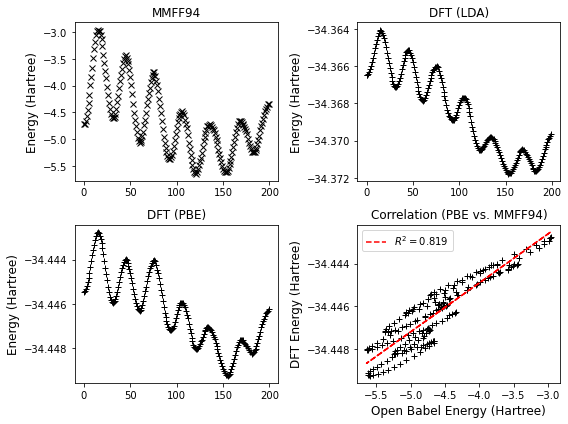

In [10]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2,2, figsize=(8,6))
axs[0,0].plot(mm_energies, 'kx')
axs[0,0].set_title("MMFF94")
axs[0,1].plot(energies["LDA"], 'k+')
axs[0,1].set_title("DFT (LDA)")
axs[1,0].plot(energies["PBE"], 'k+')
axs[1,0].set_title("DFT (PBE)")
axs[1,1].plot(mm_energies, energies["PBE"], 'k+')
plot_fit(mm_energies, energies["PBE"], axs[1,1])
axs[1,1].set_title("Correlation (PBE vs. MMFF94)")
for i in range(2):
    for j in range(2):
        axs[i, j].ticklabel_format(useOffset=False)
        axs[i, j].set_ylabel("Energy (Hartree)", fontsize=12)
axs[1,1].set_ylabel("DFT Energy (Hartree)", fontsize=12)
axs[1,1].set_xlabel("Open Babel Energy (Hartree)", fontsize=12)
axs[1,1].legend()
fig.tight_layout()

Before proceeding, let's shuffle those values to remove any time correlation when predicting.

In [11]:
from sklearn.utils import shuffle
systems, target = shuffle(systems, energies["PBE"], random_state=0)

We  are ready at this point to start with the machine learning example. We just need a very simple subroutine to convert to one of QML's fingerprints.

In [12]:
def convert_system_to_coulomb_matrix(sys, sorting="row-norm"):
    from numpy import array
    from qml.representations import generate_coulomb_matrix
    from BigDFT.Atoms import atomic_number
    
    charges = []
    coordinates = []
    
    size = sum([len(x) for x in sys.values()])
    for frag in sys.values():
        for at in frag:
            charges.append(atomic_number(at.sym))
            coordinates.append(at.get_position("angstroem"))

    return generate_coulomb_matrix(array(charges), array(coordinates),
                                                          size=size, sorting=sorting)

In [13]:
from numpy import array
reps = array([convert_system_to_coulomb_matrix(x) for x in systems])

Build our training and prediction sets.

In [14]:
training_Y = array(target[:num_training])
predict_Y = array(target[num_training:])

training_X = reps[:num_training]
predict_X = reps[num_training:]

This is all just QML boilerplate. You can play with the sigma value (the famous hyper parameter tuning).

In [15]:
from qml.kernels import gaussian_kernel
from qml.math import cho_solve
from numpy import diag_indices_from

sigma = 1000
K = gaussian_kernel(training_X, training_X, sigma)
K[diag_indices_from(K)] += 1e-8
alpha = cho_solve(K, training_Y)

In [16]:
from numpy import dot
Ks = gaussian_kernel(predict_X, training_X, sigma)
computed = dot(Ks, alpha)

Now we are ready to plot our results.

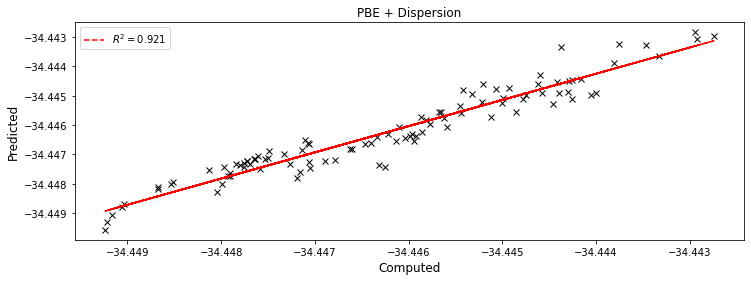

In [17]:
fig, axs = plt.subplots(1,1, figsize=(12,4))

axs.plot(predict_Y, computed, 'kx')
plot_fit(predict_Y, computed, axs)

axs.set_xlabel("Computed", fontsize=12)
axs.set_ylabel("Predicted", fontsize=12)
axs.set_title("PBE + Dispersion", fontsize=12)

axs.legend()

axs.ticklabel_format(useOffset=False)

Now we repeat this process for LDA.

In [18]:
target = shuffle(energies["LDA"], random_state=0)

In [19]:
training_Y = array(target[:num_training])
predict_Y = array(target[num_training:])

In [20]:
sigma = 1000
K = gaussian_kernel(training_X, training_X, sigma)
K[diag_indices_from(K)] += 1e-8
alpha = cho_solve(K, training_Y)
Ks = gaussian_kernel(predict_X, training_X, sigma)
computed = dot(Ks, alpha)

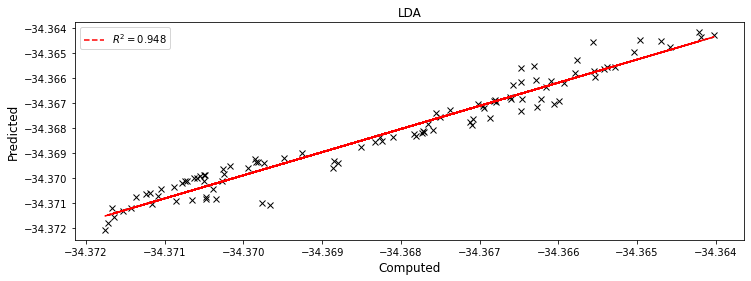

In [21]:
fig, axs = plt.subplots(1,1, figsize=(12,4))

axs.plot(predict_Y, computed, 'kx')
plot_fit(predict_Y, computed, axs)

axs.set_xlabel("Computed", fontsize=12)
axs.set_ylabel("Predicted", fontsize=12)
axs.set_title("LDA", fontsize=12)
axs.legend()

axs.ticklabel_format(useOffset=False)